# eQTL boxplot

This is script ported from python to fix unknown plotting error.

In [1]:
suppressPackageStartupMessages({
    library(tidyverse)
    library(ggpubr)
})

## Functions

In [2]:
feature = "genes"
tissue = "Caudate"

### Cached functions

In [3]:
get_residualized_df <- function(){
    expr_file = "../../_m/genes_residualized_expression.csv"
    return(data.table::fread(expr_file) %>% column_to_rownames("gene_id"))
}
memRES <- memoise::memoise(get_residualized_df)

get_biomart_df <- function(){
    biomart = data.table::fread("../_h/biomart.csv")
}
memMART <- memoise::memoise(get_biomart_df)

get_pheno_df <- function(){
    phenotype_file = paste0('/ceph/projects/v4_phase3_paper/inputs/',
                            'phenotypes/_m/merged_phenotypes.csv')
    return(data.table::fread(phenotype_file))
}
memPHENO <- memoise::memoise(get_pheno_df)

get_tissue_eqtls <- function(){
    mashr_file = paste0("../../../mashr/summary_table/_m/",
                       "BrainSeq_sexGenotypes_4features_3regions_pgc2.txt.gz")
    return(data.table::fread(mashr_file) %>% 
           filter(Type == "Gene", Tissue == "Caudate") %>% 
           select(gene_id, variant_id, lfsr))
}
memTISSUE <- memoise::memoise(get_tissue_eqtls)

get_eqtl_df <- function(){
    fastqtl_file = paste0("../../../../../prep_eqtl_analysis/",tolower(tissue),
                         "/genes/prepare_expression/fastqtl_nominal/",
                         "multiple_corrections/_m/Brainseq_LIBD.txt.gz")
    eqtl_df = data.table::fread(fastqtl_file) %>% 
        filter(gene_id %in% unique(memTISSUE()$gene_id)) %>% 
        arrange(BF)
    return(eqtl_df)
}
memEQTL <- memoise::memoise(get_eqtl_df)

get_genotypes <- function(){
    traw_file = paste0("/ceph/projects/brainseq/genotype/download/topmed/convert2plink/",
                      "filter_maf_01/a_transpose/_m/LIBD_Brain_TopMed.traw")
    traw = data.table::fread(traw_file) %>% rename_with(~ gsub('\\_.*', '', .x))
    return(traw)
}
memSNPs <- memoise::memoise(get_genotypes)

get_snp_df <- function(variant_id, gene_id){
    zz = get_geno_annot() %>% filter(SNP == variant_id)
    xx = get_snps_df() %>% filter(SNP == variant_id) %>% 
        column_to_rownames("SNP") %>% t %>% as.data.frame %>% 
        rownames_to_column("BrNum") %>% mutate(COUNTED=zz$COUNTED, ALT=zz$ALT) %>% 
        rename("SNP"=all_of(variant_id))
    yy = memRES()[gene_id, ] %>% t %>% as.data.frame %>% 
        rownames_to_column("RNum") %>% inner_join(memPHENO(), by="RNum")
    ## Annotated SNPs
    letters = c()
    for(ii in seq_along(xx$COUNTED)){
        a0 = xx$COUNTED[ii]; a1 = xx$ALT[ii]; number = xx$SNP[ii]
        letters <- append(letters, letter_snp(number, a0, a1))
    }
    xx = xx %>% mutate(LETTER=letters, ID=paste(SNP, LETTER, sep="\n"))
    df = inner_join(xx, yy, by="BrNum") %>% mutate_if(is.character, as.factor)
    return(df)
}
memDF <- memoise::memoise(get_snp_df)

### Simple functions

In [4]:
get_geno_annot <- function(){
    return(memSNPs() %>% select(CHR, SNP, POS, COUNTED, ALT))
}

get_snps_df <- function(){
    return(memSNPs() %>% select("SNP", starts_with("Br")))
}

letter_snp <- function(number, a0, a1){
    if(is.na(number)){ return(NA) }
    if( length(a0) == 1 & length(a1) == 1){
        seps = ""; collapse=""
    } else {
        seps = " "; collapse=NULL
    }
    return(paste(paste0(rep(a0, number), collapse = collapse), 
                 paste0(rep(a1, (2-number)), collapse = collapse), sep=seps))
}

save_ggplots <- function(fn, p, w, h){
    for(ext in c('.pdf', '.png', '.svg')){
        ggsave(paste0(fn, ext), plot=p, width=w, height=h)
    }
}

get_gene_symbol <- function(gene_id){
    ensemblID = gsub("\\..*", "", gene_id)
    geneid = memMART() %>% filter(ensembl_gene_id == gsub("\\..*", "", gene_id))
    if(dim(geneid)[1] == 0){
        return("")
    } else {
        return(geneid$external_gene_name)
    }
}

plot_simple_eqtl <- function(fn, gene_id, variant_id, eqtl_annot){
    bxp = memDF(variant_id, gene_id) %>%
        ggboxplot(x="ID", y=gene_id, fill="Sex", color="Sex", add="jitter", 
                  facet.by="Region", panel.labs.font=list(face='bold'),
                  xlab=variant_id, ylab="Residualized Expression", outlier.shape=NA,
                  add.params=list(alpha=0.5), alpha=0.4, legend="bottom", 
                  palette="npg", ggtheme=theme_pubr(base_size=20, border=TRUE)) +
        font("xy.title", face="bold") + 
        ggtitle(paste(get_gene_symbol(gene_id), gene_id, eqtl_annot, sep='\n')) +
        theme(plot.title = element_text(hjust = 0.5, face="bold"))
    print(bxp)
    save_ggplots(fn, bxp, 10, 7)
}

### GWAS plots

In [5]:
get_gwas_snps <- function(){
    gwas_snp_file = paste0('/ceph/projects/v4_phase3_paper/inputs/sz_gwas/pgc2_clozuk/',
                          'map_phase3/_m/libd_hg38_pgc2sz_snps_p5e_minus8.tsv')
    gwas_df = data.table::fread(gwas_snp_file) %>% arrange(P)
    return(gwas_df)
}
memGWAS <- memoise::memoise(get_gwas_snps)

get_gwas_snp <- function(variant){
    return(memGWAS() %>% filter(our_snp_id == variant))
}

get_risk_allele <- function(variant){
    gwas_snp = get_gwas_snp(variant)
    if(gwas_snp$OR > 1){
        ra = gwas_snp$A1
    }else{
        ra = gwas_snp$A2
    }
    return(ra)
}

get_eqtl_gwas_df <- function(){
    return(memTISSUE() %>% inner_join(memGWAS(), by=c("variant_id"="our_snp_id")))
}

get_gwas_ordered_snp_df <- function(variant_id, gene_id, pgc2_a1_same_as_our_counted, OR){
    df = memDF(variant_id, gene_id)
    if(!pgc2_a1_same_as_our_counted){ # Fix bug with matching alleles!
        if(OR < 1){ df = df %>% mutate(SNP = 2-SNP, ID=paste(SNP, LETTER, sep="\n")) }
    } else {
        if(OR > 1){ df = df %>% mutate(SNP = 2-SNP, ID=paste(SNP, LETTER, sep="\n")) }
    }
    return(df)
}

plot_gwas_eqtl <- function(fn, gene_id, variant_id, pgc2_a1_same_as_our_counted, OR, title){
    dt = get_gwas_ordered_snp_df(variant_id, gene_id, pgc2_a1_same_as_our_counted, OR) 
    y0 = quantile(dt[[gene_id]], probs=c(0.05))[[1]] - 0.26
    y1 = quantile(dt[[gene_id]], probs=c(0.95))[[1]] + 0.26
    bxp = dt %>% mutate_if(is.character, as.factor) %>%
        mutate(Region=gsub("HIPPO", "Hippocampus", Region)) %>%
        ggboxplot(x="ID", y=gene_id, fill="Sex", color="Sex", add="jitter", 
                  facet.by="Region", panel.labs.font=list(face='bold'),
                  xlab=variant_id, ylab="Residualized Expression", outlier.shape=NA,
                  add.params=list(alpha=0.5), alpha=0.4, legend="bottom", lims=c(y0,y1),
                  palette="npg", ggtheme=theme_pubr(base_size=20, border=TRUE)) +
        font("xy.title", face="bold") + ggtitle(title) +
        theme(plot.title = element_text(hjust = 0.5, face="bold"))
    print(bxp)
    save_ggplots(fn, bxp, 10, 8)
}

## Plot eQTL

### Top 5 GWAS associated eQTLs

In [6]:
eqtl_gwas_df = get_eqtl_gwas_df() %>% group_by(gene_id) %>% arrange(lfsr) %>% 
    slice(1) %>% inner_join(select(get_eqtl_df(), -variant_id), by=c("gene_id")) %>%
    select(variant_id, gene_id, slope, BF, pgc2_a1_same_as_our_counted, OR, P)
eqtl_gwas_df

variant_id,gene_id,slope,BF,pgc2_a1_same_as_our_counted,OR,P
<chr>,<chr>,<dbl>,<dbl>,<lgl>,<dbl>,<dbl>
chr2:232928501:T:C,ENSG00000182600.9,0.424601,1.085450e-01,FALSE,0.9342,1.63e-12
chr6:29688639:T:G,ENSG00000227262.3,0.499502,5.440699e-02,FALSE,1.0948,6.88e-15
chr6:31867387:G:C,ENSG00000244731.7,-0.632753,7.852384e-05,FALSE,1.1744,1.05e-29


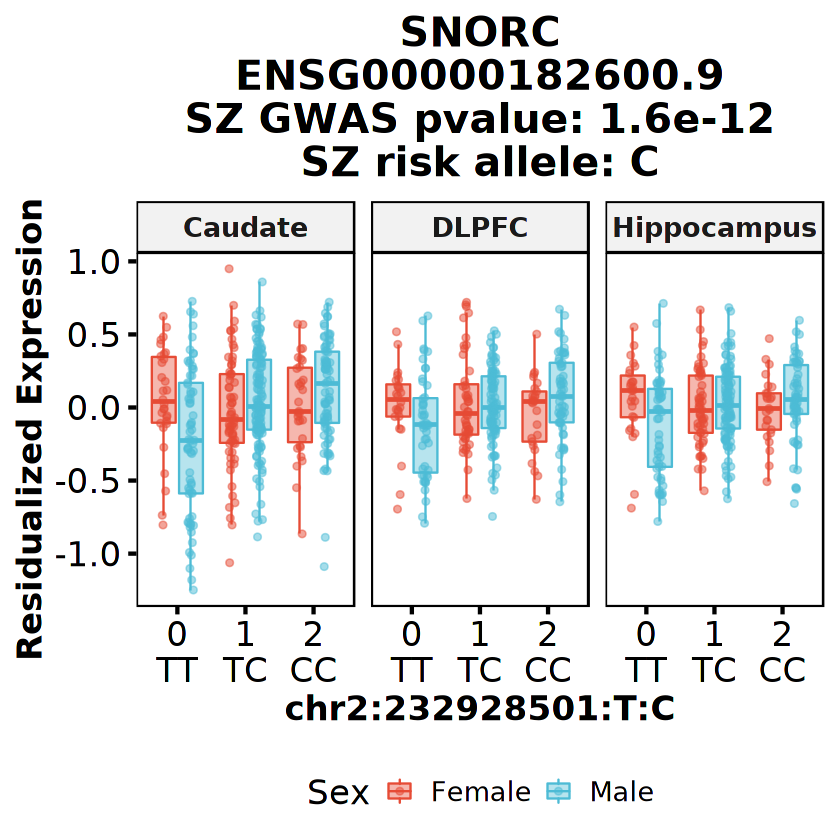

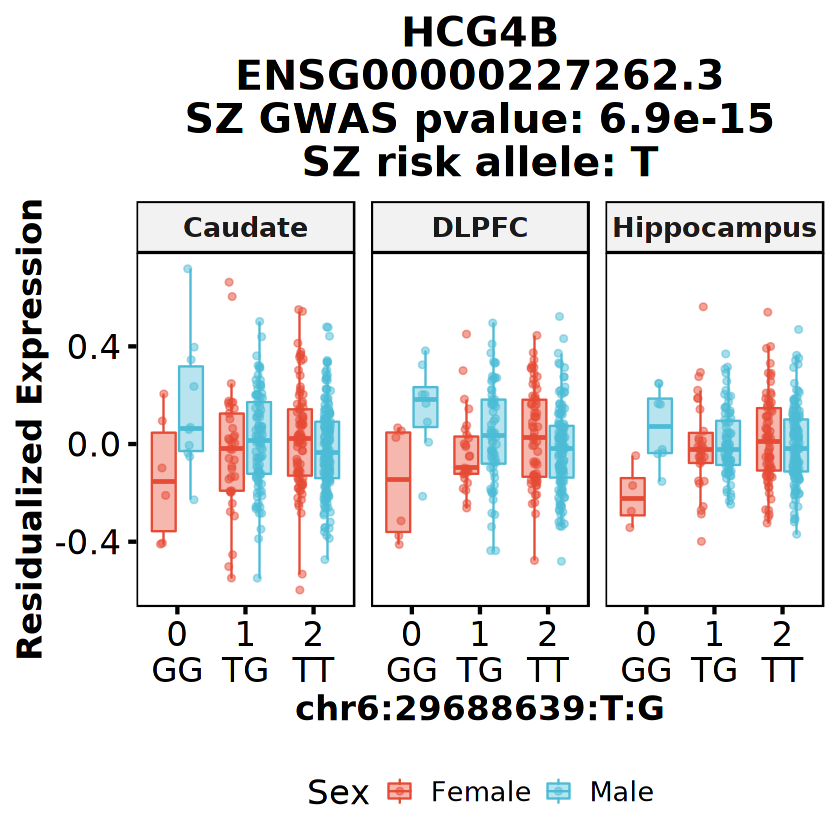

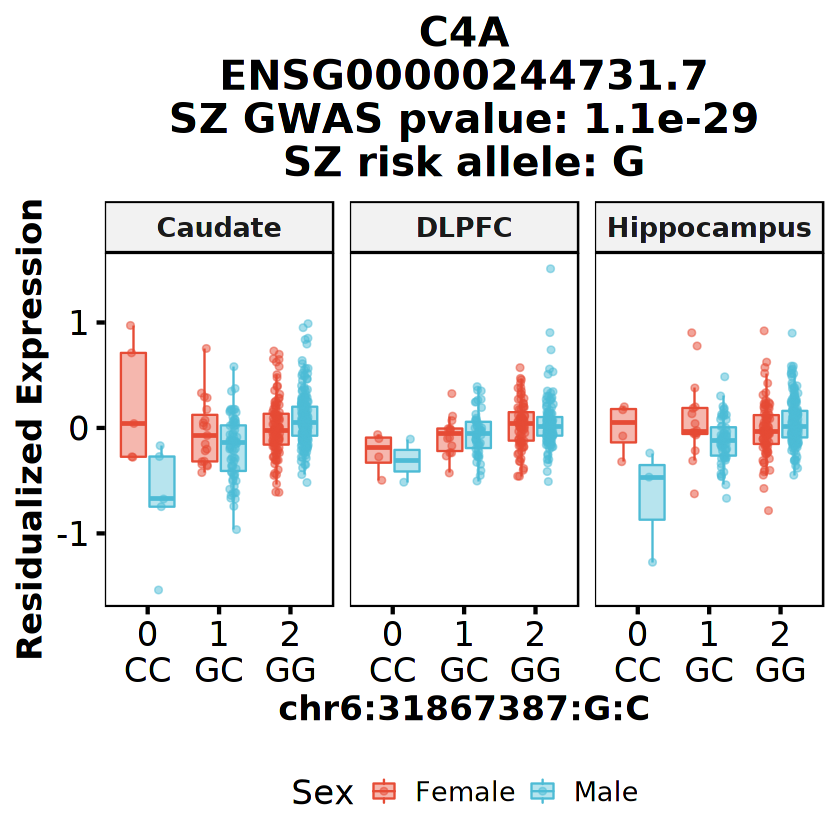

In [7]:
for(num in seq_along(eqtl_gwas_df$gene_id)){
    fn = paste("top",num,"interacting_eqtl_in_gwas_significant_snps", sep="_")
    variant_id = eqtl_gwas_df$variant_id[num]
    gene_id = eqtl_gwas_df$gene_id[num]
    pgc2_a1_same_as_our_counted = eqtl_gwas_df$pgc2_a1_same_as_our_counted[num]
    OR = eqtl_gwas_df$OR[num]
    #eqtl_annot = paste("eQTL q-value:", signif(eqtl_gwas_df$BF[num], 2))
    gwas_annot = paste("SZ GWAS pvalue:", signif(eqtl_gwas_df$P[num], 2))
    risk_annot = paste("SZ risk allele:", get_risk_allele(eqtl_gwas_df$variant_id[num]))
    title = paste(get_gene_symbol(gene_id), gene_id, gwas_annot, risk_annot, sep='\n')
    plot_gwas_eqtl(fn, gene_id, variant_id, pgc2_a1_same_as_our_counted, OR, title)
}

## Session Info

In [8]:
Sys.time()
proc.time()
options(width = 120)
sessioninfo::session_info()

[1] "2021-09-13 18:45:17 EDT"

    user   system  elapsed 
1343.547  259.678  262.759 

─ Session info ───────────────────────────────────────────────────────────────────────────────────────────────────────
 setting  value                       
 version  R version 4.0.3 (2020-10-10)
 os       Arch Linux                  
 system   x86_64, linux-gnu           
 ui       X11                         
 language (EN)                        
 collate  en_US.UTF-8                 
 ctype    en_US.UTF-8                 
 tz       America/New_York            
 date     2021-09-13                  

─ Packages ───────────────────────────────────────────────────────────────────────────────────────────────────────────
 package     * version  date       lib source        
 abind         1.4-5    2016-07-21 [1] CRAN (R 4.0.2)
 assertthat    0.2.1    2019-03-21 [1] CRAN (R 4.0.2)
 backports     1.2.1    2020-12-09 [1] CRAN (R 4.0.2)
 base64enc     0.1-3    2015-07-28 [1] CRAN (R 4.0.2)
 broom         0.7.9    2021-07-27 [1] CRAN (R 4.0.3)
 cachem        1.0.6    2021-08-19 [1] CRAN (R 